# Midterm-Project: Walkability Accessment of Graz, Austria

Authors: Bernadette Kakuska, Clemens Wallisch, Elias Pfleger, Paul Badin

Course: GIS analysis techniques 2 (VU, WS25)

Date: 07/12/2025

> Kevic, K., Kuveždic Divjak, A., Zrno, K., and Vilicic, M. (2024). Open Data Supporting GIS-based Walkability Assessment: Case Study for City of Zagreb, Croatia, Int. Arch. Photogramm. Remote Sens. Spatial Inf. Sci., XLVIII-5-2024, 23–29, https://doi.org/10.5194/isprs-archives-XLVIII-5-2024-23-2024.

### Data Preparation

In [278]:
# import libraries
import pandas as pd        
import numpy as np
import geopandas as gpd
from shapely import wkt
from shapely.geometry import Polygon
import osmnx as ox
import matplotlib.pyplot as plt
import networkx as nx   # for computing walking distances

from keplergl import KeplerGl   # for Visualisation

import h3   # Hexagonal grid indexing for Spatial analysis

import rasterio
import rasterio.mask

Load the districts of Graz and merge them with the pop csv  (shp data converted in QGIS from Overpass)
(source of population data: https://www.graz.at/cms/beitrag/10034466/7772565/Zahlen_Fakten_Bevoelkerung_Bezirke_Wirtschaft.html)

In [279]:
#get the districts of Graz
gdf_districts = gpd.read_file("data/district_graz.geojson")
print(gdf_districts.head(3))
print(f"\nTotal numbers of districts: {len(gdf_districts)}")

                id              @id @relations admin_level        boundary  \
0  relation/102537  relation/102537       None           9  administrative   
1  relation/102546  relation/102546       None           9  administrative   
2  relation/102553  relation/102553       None           9  administrative   

             name official_name postal_code ref:at:okz      type  wikidata  \
0    Innere Stadt          None        None      17453  boundary   Q250880   
1        Liebenau          None        None       None  boundary   Q876432   
2  Sankt Leonhard  St. Leonhard        None      17454  boundary  Q1530101   

                wikipedia                                           geometry  
0  de:Innere Stadt (Graz)  POLYGON ((15.44371 47.06706, 15.44372 47.06707...  
1      de:Liebenau (Graz)  POLYGON ((15.468 47.04249, 15.46799 47.04257, ...  
2  de:St. Leonhard (Graz)  POLYGON ((15.46177 47.06758, 15.46181 47.06761...  

Total numbers of districts: 34


             name                                           geometry
0    Innere Stadt  POLYGON ((15.44371 47.06706, 15.44372 47.06707...
1        Liebenau  POLYGON ((15.468 47.04249, 15.46799 47.04257, ...
2  Sankt Leonhard  POLYGON ((15.46177 47.06758, 15.46181 47.06761...
3         Geidorf  POLYGON ((15.42348 47.09566, 15.42338 47.09547...


<Axes: >

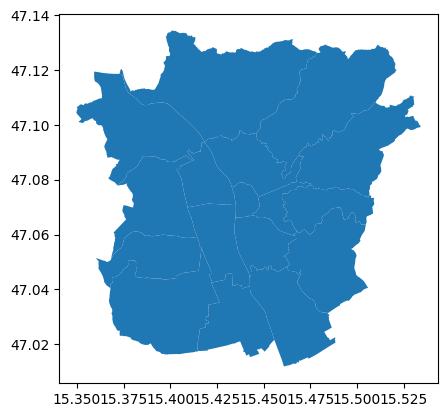

In [280]:
#extract the columns which are needed
gdf_districts = gdf_districts[["name", "geometry"]].copy()
print(gdf_districts.head(4))
gdf_districts.plot()

In [281]:
#loading csv with pop data of graz 
df_popgraz = pd.read_csv("data/Bevoelkerung Graz.csv", encoding="latin1", sep=";")
df_popgraz.head(18)

,Bezirk,Größe in km2,Einwohner,Einwohner pro km2
0,Innere Stadt,"1,16",3184,2745
1,Sankt Leonhard,"1,83",14692,8028
2,Geidorf,"5,5",23770,4322
3,Lend,"3,7",34308,9324
4,Gries,"5,05",30511,6042
5,Jakomini,"4,06",32114,7910
6,Liebenau,"7,99",16588,2076
7,Sankt Peter,"8,86",16615,1875
8,Waltendorf,"4,48",12432,2775
9,Ries,"10,16",6099,600


In [282]:
#merge the two datasets
gdf_districts_pop = gdf_districts.merge(df_popgraz, left_on="name", right_on="Bezirk")
gdf_districts_pop.head(3)

,name,geometry,Bezirk,Größe in km2,Einwohner,Einwohner pro km2
0,Innere Stadt,"POLYGON ((15.44371 47.06706, 15.44372 47.06707...",Innere Stadt,"1,16",3184,2745
1,Liebenau,"POLYGON ((15.468 47.04249, 15.46799 47.04257, ...",Liebenau,"7,99",16588,2076
2,Sankt Leonhard,"POLYGON ((15.46177 47.06758, 15.46181 47.06761...",Sankt Leonhard,"1,83",14692,8028


Get the POIs and merge them into one GDF

In [283]:
PLACE_NAME:str = "Graz, Austria"

                                    geometry category
element id                                           
node    251710886  POINT (15.43675 47.07188)   retail
        271624001  POINT (15.47242 47.05671)   retail
        278691038   POINT (15.4427 47.06992)   retail
        288172339  POINT (15.40841 47.07185)   retail
        290422098  POINT (15.45518 47.06741)   retail


<Axes: >

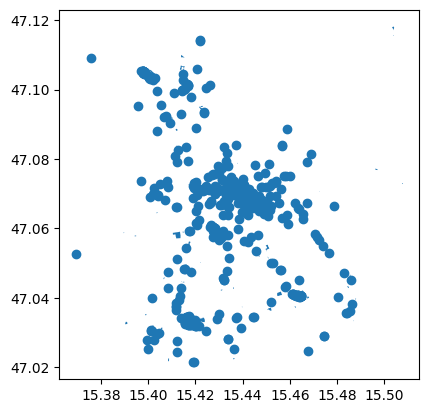

In [284]:
tags_retail = {
    "shop": [
        "clothes", "shoes", "furniture", "electronics", "computer",
        "mobile_phone", "kitchen", "houseware", "hardware", "doityourself",
        "books", "stationery", "jewelry", "boutique", "sports", "outdoor",
        "bicycle", "car", "car_repair", "motorcycle",
        "department_store", "mall", "variety_store", "general"
    ]
}

gdf_retail = ox.features_from_place(PLACE_NAME, tags_retail)
gdf_retail = gdf_retail[["geometry"]].copy()
gdf_retail["category"] = "retail"
print(gdf_retail.head(5))
gdf_retail.plot()


                                   geometry category
element id                                          
node    21015347  POINT (15.43238 47.02987)     food
        26899232  POINT (15.44826 47.07568)     food
        31611256   POINT (15.4581 47.06301)     food
        31620673   POINT (15.4342 47.02831)     food
        31620704  POINT (15.46442 47.03997)     food


<Axes: >

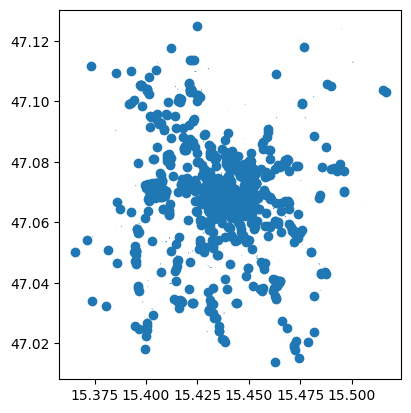

In [285]:
tags_food = {
    "amenity": [
        "supermarket", "marketplace", "greengrocer",
        "restaurant", "cafe", "fast_food", "ice_cream",
        "bar", "pub", "biergarten",
        "bakery"
    ],
    "shop": ["supermarket", "convenience", "greengrocer", "butcher", "seafood"]
}

gdf_food = ox.features_from_place(PLACE_NAME, tags_food)
gdf_food = gdf_food[["geometry"]].copy()
gdf_food["category"] = "food"
print(gdf_food.head(5))
gdf_food.plot()

                                    geometry       category
element id                                                 
node    31625435   POINT (15.43796 47.06991)  entertainment
        31625437      POINT (15.45 47.06382)  entertainment
        107935777  POINT (15.43765 47.04397)  entertainment
        251710896  POINT (15.44063 47.07142)  entertainment
        492011184  POINT (15.39263 47.07637)  entertainment


<Axes: >

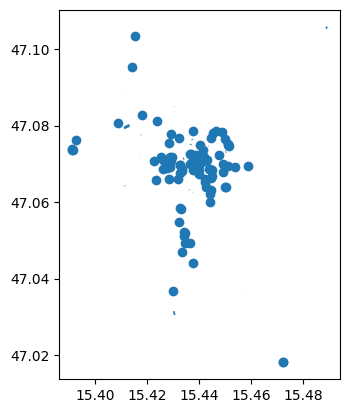

In [286]:
tags_entertainment = {
    "amenity": ["cinema", "theatre", "arts_centre", "nightclub", "casino"],
    "tourism": ["museum", "gallery"]
}

gdf_entertainment = ox.features_from_place(PLACE_NAME, tags_entertainment)
gdf_entertainment = gdf_entertainment[["geometry"]].copy()
gdf_entertainment["category"] = "entertainment"
print(gdf_entertainment.head(5))
gdf_entertainment.plot()

                                    geometry category
element id                                           
node    266657602  POINT (15.45089 47.06318)   office
        279089642  POINT (15.43966 47.07262)   office
        369490755  POINT (15.43934 47.06822)   office
        569570749  POINT (15.44646 47.07484)   office
        837234659  POINT (15.43417 47.05871)   office
<class 'geopandas.geodataframe.GeoDataFrame'>
MultiIndex: 963 entries, ('node', np.int64(266657602)) to ('way', np.int64(1410449338))
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype   
---  ------    --------------  -----   
 0   geometry  963 non-null    geometry
 1   category  963 non-null    object  
dtypes: geometry(1), object(1)
memory usage: 90.2+ KB


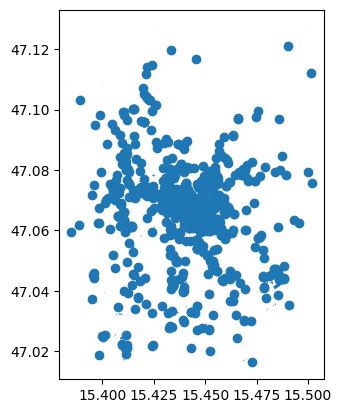

In [287]:
tags_office = {"office": True}
gdf_office = ox.features_from_place(PLACE_NAME, tags_office)
gdf_office = gdf_office[["geometry"]].copy()    
gdf_office["category"] = "office"
print(gdf_office.head(5))
gdf_office.plot()
gdf_office.info()

                                    geometry category
element id                                           
node    26899380   POINT (15.43737 47.06753)    civic
        26899638   POINT (15.46345 47.06607)    civic
        26899640   POINT (15.43932 47.06861)    civic
        117124121     POINT (15.483 47.0471)    civic
        269062537  POINT (15.41311 47.06663)    civic


<Axes: >

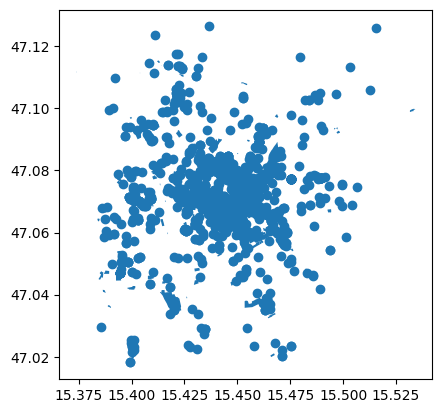

In [288]:
tags_civic = {
    "amenity": [
        "school", "university", "college",
        "hospital", "clinic", "doctors", "dentist",
        "police", "fire_station", "townhall",
        "library", "post_office", "courthouse"
    ]
}
gdf_civic = ox.features_from_place(PLACE_NAME, tags_civic)
gdf_civic = gdf_civic[["geometry"]].copy()
gdf_civic["category"] = "civic"
print(gdf_civic.head(5))
gdf_civic.plot()

                                    geometry category
element id                                           
node    197819750  POINT (15.45903 47.07323)    sport
        278113673  POINT (15.42145 47.07183)    sport
        291464359  POINT (15.45846 47.07323)    sport
        859421763  POINT (15.38524 47.09008)    sport
        940994980  POINT (15.42787 47.08845)    sport
<class 'geopandas.geodataframe.GeoDataFrame'>
MultiIndex: 5427 entries, ('node', np.int64(197819750)) to ('way', np.int64(1452490981))
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype   
---  ------    --------------  -----   
 0   geometry  5427 non-null   geometry
 1   category  5427 non-null   object  
dtypes: geometry(1), object(1)
memory usage: 401.4+ KB


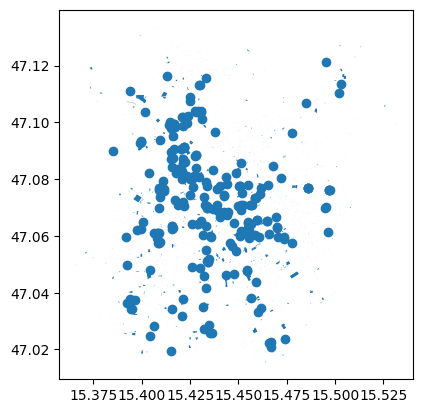

In [289]:
sport_tags = {
    "leisure": [
        "sports_centre", "pitch", "stadium", "swimming_pool", "fitness_centre",
        "playground", "miniature_golf"
    ],
}

gdf_sport = ox.features_from_place(PLACE_NAME, sport_tags)
gdf_sport = gdf_sport[["geometry"]].copy()
gdf_sport["category"] = "sport"
print(gdf_sport.head(5))
gdf_sport.plot()
gdf_sport.info()

In [290]:
#only point geometry for POIs
def only_points (gdf):
    gdf = gdf[["geometry", "category"]].copy()
    gdf = gdf.to_crs("EPSG:32633") #UTM zone 33N for Graz
    gdf['geometry'] = gdf.geometry.centroid
    gdf = gdf.to_crs("EPSG:4326") #back to WGS84
    gdf = gdf[gdf.geometry.type == "Point"].copy()
    gdf = gdf.reset_index(drop=True)
    return gdf

In [291]:
gdf_retail = only_points(gdf_retail)
gdf_food = only_points(gdf_food)
gdf_civic = only_points(gdf_civic)
gdf_sport = only_points(gdf_sport)
gdf_office = only_points(gdf_office)
gdf_entertainment = only_points(gdf_entertainment)

In [292]:
gdf_retail.head(3)

,geometry,category
0,POINT (15.43675 47.07188),retail
1,POINT (15.47242 47.05671),retail
2,POINT (15.4427 47.06992),retail


In [293]:
#final merge of all POI categories
gdf_pois = gpd.GeoDataFrame(pd.concat([gdf_retail, gdf_food, gdf_civic, gdf_sport, gdf_office, gdf_entertainment], ignore_index=True))
gdf_pois.info()
gdf_pois['category'].value_counts()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 10147 entries, 0 to 10146
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype   
---  ------    --------------  -----   
 0   geometry  10147 non-null  geometry
 1   category  10147 non-null  object  
dtypes: geometry(1), object(1)
memory usage: 158.7+ KB


category
sport            5427
civic            1503
food             1402
office            963
retail            726
entertainment     126
Name: count, dtype: int64

Add Blues and Greens of Graz 

> Source: https://land.copernicus.eu/en/products/urban-atlas?tab=land_coverland_use

In [294]:
gdf_greenspaces = gpd.read_file("data/AT002L3_GRAZ_UA2018_v013.gpkg")
print(gdf_greenspaces.head(3))
gdf_greenspaces["class_2018"].value_counts()

c:\Users\elias\OneDrive\MasterGST\3. Semester\GIS_Analyse2\venv-gst200b\Lib\site-packages\pyogrio\geopandas.py:275: UserWarning: More than one layer found in 'AT002L3_GRAZ_UA2018_v013.gpkg': 'AT002L3_GRAZ_UA2018' (default), 'AT002L3_GRAZ_UA2018_Boundary', 'AT002L3_GRAZ_UA2018_UrbanCore'. Specify layer parameter to avoid this warning.
  result = read_func(


  country fua_name fua_code code_2018  \
0      AT     Graz  AT002L3     11220   
1      AT     Graz  AT002L3     11220   
2      AT     Graz  AT002L3     12100   

                                          class_2018 prod_date     identifier  \
0  Discontinuous medium density urban fabric (S.L...   2020-08   3208-AT002L3   
1  Discontinuous medium density urban fabric (S.L...   2020-08   6149-AT002L3   
2  Industrial, commercial, public, military and p...   2020-08  30126-AT002L3   

     perimeter           area comment  Pop2018  \
0   278.704449    4688.441889    None        9   
1  4009.964320  130449.086096    None      535   
2   309.287086    5366.132708    None        0   

                                            geometry  
0  MULTIPOLYGON (((4738225.83 2658159.675, 473830...  
1  MULTIPOLYGON (((4735000 2679302.11, 4734969.52...  
2  MULTIPOLYGON (((4770976 2678000.023, 4770982.5...  


class_2018
Isolated structures                                                 8874
Discontinuous low density urban fabric (S.L. : 10% - 30%)           8547
Pastures                                                            8464
Arable land (annual crops)                                          7226
Discontinuous medium density urban fabric (S.L. : 30% - 50%)        5947
Forests                                                             4339
Industrial, commercial, public, military and private units          3215
Discontinuous very low density urban fabric (S.L. : < 10%)          2692
Discontinuous dense urban fabric (S.L. : 50% -  80%)                1697
Land without current use                                             594
Green urban areas                                                    356
Sports and leisure facilities                                        334
Water                                                                331
Continuous urban fabric (S.L. : > 80%)  

                                            geometry         class_2018  \
0  MULTIPOLYGON (((4735867.556 2661054.437, 47358...  Green urban areas   
1  MULTIPOLYGON (((4738389.463 2668813.812, 47383...  Green urban areas   
2  MULTIPOLYGON (((4768619.299 2676992.77, 476860...  Green urban areas   

  code_2018  
0     14100  
1     14100  
2     14100  


<Axes: >

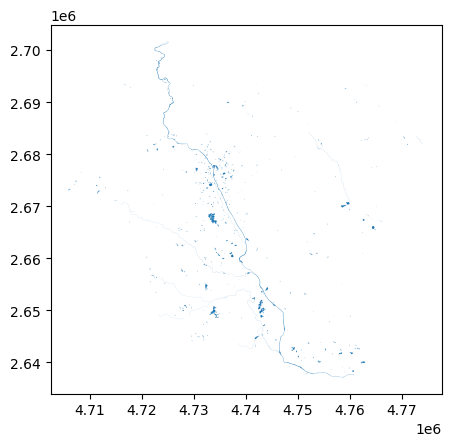

In [295]:
gdf_greens_blue = gdf_greenspaces[gdf_greenspaces["class_2018"].isin(["Green urban areas", "Water"])].copy()
gdf_greens_blue = gdf_greens_blue[["geometry", "class_2018", "code_2018"]].copy()
gdf_greens_blue = gdf_greens_blue.reset_index(drop=True)
print(gdf_greens_blue.head(3))
gdf_greens_blue.plot()

Get the walking network of Graz for routing


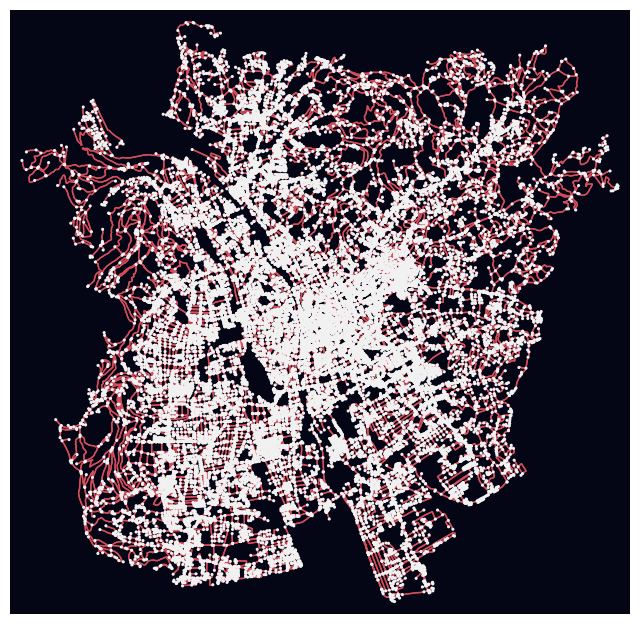

In [296]:
G = ox.graph_from_place(PLACE_NAME, network_type="walk")
G = ox.project_graph(G, to_crs = "EPSG:32633")
fig, ax = ox.plot_graph(G, node_size=5, bgcolor= "#040615", node_color='#f1f1f1', edge_color='#d44e5c')

### Analysis

Create H3-Grid

           name                                           geometry  \
0  Innere Stadt  POLYGON ((15.43705 47.07588, 15.43486 47.07135...   
1      Liebenau  POLYGON ((15.45699 47.05012, 15.4548 47.04559,...   
2      Liebenau  POLYGON ((15.45043 47.03654, 15.44824 47.03201...   
3      Liebenau  POLYGON ((15.45578 47.02079, 15.45359 47.01626...   
4      Liebenau  POLYGON ((15.44775 47.04441, 15.44557 47.03988...   

         Bezirk Größe in km2  Einwohner  Einwohner pro km2         h3_cells  
0  Innere Stadt         1,16       3184               2745  881e10a12bfffff  
1      Liebenau         7,99      16588               2076  881e10aac3fffff  
2      Liebenau         7,99      16588               2076  881e10aa8dfffff  
3      Liebenau         7,99      16588               2076  881e10aaabfffff  
4      Liebenau         7,99      16588               2076  881e10aac7fffff  


<Axes: >

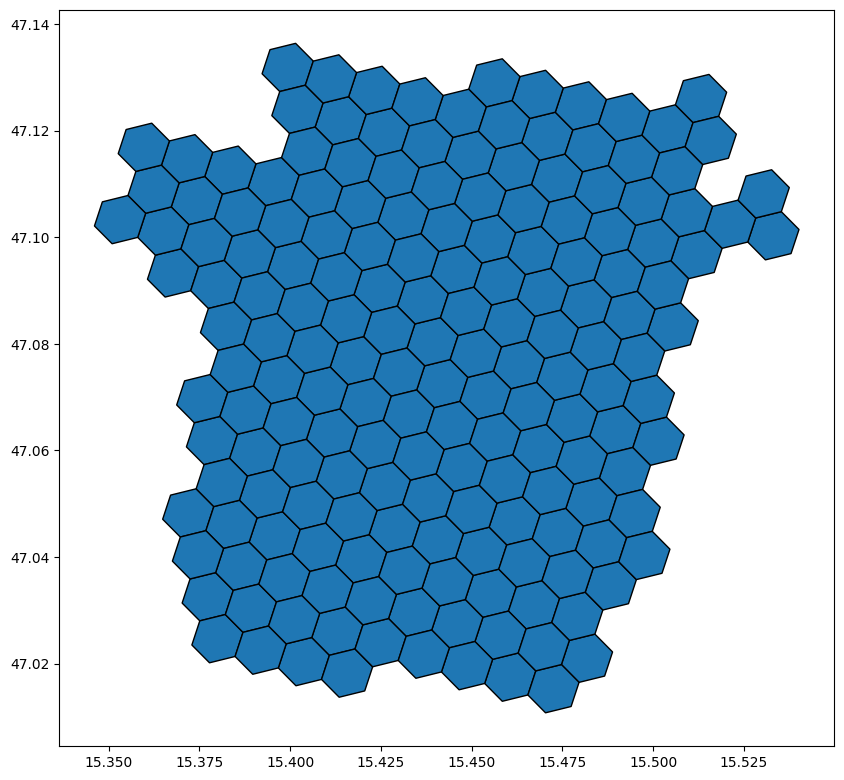

In [297]:
H3_RESOLUTION = 8  # Kevic et al. (2024) uses 500 m × 500 m square grid -> h3res=8 for Graz ~500m hexagons 

# function to convert a shapely polygon to H3 cells (v4 API)
def polygon_to_h3(polygon: Polygon, resolution=H3_RESOLUTION):
    """
    Converts a shapely Polygon to a list of H3 hex IDs.
    Works with H3 v4.x API.
    """
    # shapely uses (x=lon, y=lat), H3 expects (lat, lon)
    exterior = [(lat, lon) for lon, lat in polygon.exterior.coords]
    
    # handle interiors (holes)
    interiors = [[(lat, lon) for lon, lat in interior.coords] for interior in polygon.interiors]

    # create H3 LatLng polygon
    
    shape = h3.LatLngPoly(exterior, interiors)
    
    # get all H3 hexagons covering the polygon
    return list(h3.polygon_to_cells(shape, resolution))


# apply to all districts (use combined dataset)
gdf_districts_pop["h3_cells"] = gdf_districts_pop["geometry"].apply(polygon_to_h3)

# explode into one row per H3 cell for easier analysis
gdf_hex = gdf_districts_pop.explode("h3_cells").reset_index(drop=True)

# convert H3 cells to shapely polygons (v4.x API)
gdf_hex["geometry"] = gdf_hex["h3_cells"].apply(
    lambda cell: Polygon([
        (lon, lat) for lat, lon in h3.cell_to_boundary(cell)
    ])
)

# create geodataframe
gdf_hex = gpd.GeoDataFrame(gdf_hex, geometry="geometry", crs="EPSG:4326")

# Cleaning
gdf_hex = gdf_hex.drop_duplicates(subset='h3_cells', keep='first').reset_index(drop=True)

# check result
print(gdf_hex.head())
gdf_hex.plot(edgecolor="k", figsize=(10,10))

Connect POIs + H3

  Pixel size: 21.09m x 30.92m
  Elevation range: 316.35m to 790.04m
  Slope range: 0.00° to 55.74°
SLOPE STATISTICS
Lowest slope:  1.67°
Highest slope: 24.04°
Mean slope:    8.91°
Hexagons with slope > 5°: 112


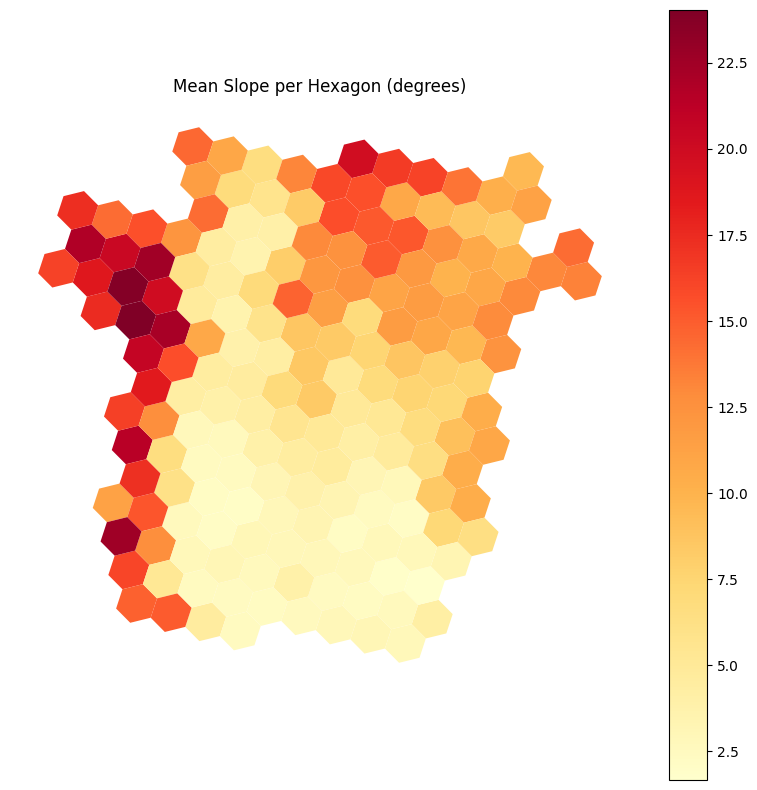

In [ ]:
# Slope per hexagon from DEM raster 
slope_raster_path = "data/DEM30_Graz.tif"

# Calculate slope (DEM is in WGS84)
with rasterio.open(slope_raster_path) as src:
    elevation = src.read(1)
    transform = src.transform
    nodata = src.nodata
    
    lat_center = 47.0  # Approximate latitude of Graz
    
    # Pixel size in degrees
    pixel_size_lon = abs(transform[0])  
    pixel_size_lat = abs(transform[4])  
    
    # Convert to meters 
    meters_per_degree_lat = 111320  
    meters_per_degree_lon = 111320 * np.cos(np.radians(lat_center)) 
    
    pixel_size_x_m = pixel_size_lon * meters_per_degree_lon
    pixel_size_y_m = pixel_size_lat * meters_per_degree_lat
    
    print(f"  Pixel size: {pixel_size_x_m:.2f}m x {pixel_size_y_m:.2f}m")
    print(f"  Elevation range: {elevation.min():.2f}m to {elevation.max():.2f}m")
    
    # Calculate gradients in meters
    dy, dx = np.gradient(elevation, pixel_size_y_m, pixel_size_x_m)
    
    # Calculate slope in degrees
    slope_radians = np.arctan(np.sqrt(dx**2 + dy**2))
    slope_degrees = np.rad2deg(slope_radians)
    
    print(f"  Slope range: {slope_degrees.min():.2f}° to {slope_degrees.max():.2f}°")
    
    # Handle nodata
    if nodata is not None:
        slope_degrees[elevation == nodata] = -9999
    
    # Save slope raster
    slope_profile = src.profile.copy()
    slope_profile.update(dtype=rasterio.float32, nodata=-9999)
    
    slope_output_path = "data/DEM30_Graz_slope.tif"
    with rasterio.open(slope_output_path, 'w', **slope_profile) as dst:
        dst.write(slope_degrees.astype(rasterio.float32), 1)
    

# Extract mean slope per hexagon
mean_slopes = []
valid_extractions = 0

with rasterio.open(slope_output_path) as src:

    for idx, row in gdf_hex.iterrows():
        geom = [row.geometry.__geo_interface__]
        try:
            out_image, out_transform = rasterio.mask.mask(
                src, geom, crop=True, all_touched=True
            )
            data = out_image[0]
            
            # Remove NoData values
            data = data[(data != -9999) & (data >= 0)]
            
            if data.size > 0:
                mean_slope = float(data.mean())
                valid_extractions += 1
            else:
                mean_slope = 0.0
        except ValueError:
            mean_slope = 0.0
        
        mean_slopes.append(mean_slope)


gdf_hex["slope_deg"] = mean_slopes

# Statistics
print(f"Lowest slope:  {gdf_hex['slope_deg'].min():.2f}°")
print(f"Highest slope: {gdf_hex['slope_deg'].max():.2f}°")
print(f"Mean slope:    {gdf_hex['slope_deg'].mean():.2f}°")
print(f"Hexagons with slope > 5°: {(gdf_hex['slope_deg'] > 5).sum()}")

# Visualization
gdf_hex.plot(column='slope_deg', cmap='YlOrRd', legend=True, figsize=(10, 10))
plt.title('Mean Slope per Hexagon (degrees)')
plt.axis('off')
plt.show()

In [299]:
# Assign each POI to an H3 cel
def point_to_h3(point, res=H3_RESOLUTION):
    lat, lon = point.y, point.x
    return h3.latlng_to_cell(lat, lon, res)

gdf_pois["h3_cell"] = gdf_pois["geometry"].apply(point_to_h3)
# Now every POI has the H3 cell in which it lies.

In [300]:
# Prepare hex centroids (for distances)
gdf_hex["centroid"] = gdf_hex.geometry.centroid
gdf_hex["lat"] = gdf_hex.centroid.y
gdf_hex["lon"] = gdf_hex.centroid.x

C:\Users\elias\AppData\Local\Temp\ipykernel_24540\212735153.py:2: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf_hex["centroid"] = gdf_hex.geometry.centroid
C:\Users\elias\AppData\Local\Temp\ipykernel_24540\212735153.py:3: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf_hex["lat"] = gdf_hex.centroid.y
C:\Users\elias\AppData\Local\Temp\ipykernel_24540\212735153.py:4: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf_hex["lon"] = gdf_hex.centroid.x


In [301]:
# Build a nearest-POI lookup using pandas merge + groupby
pois_df = pd.DataFrame({
    "h3_cell": gdf_pois["h3_cell"],
    "poi_lat": gdf_pois.geometry.y,
    "poi_lon": gdf_pois.geometry.x,
    "category": gdf_pois["category"]
})

Compute distance to nearest POI per hex

In [302]:
# using haversine
def haversine(lat1, lon1, lat2, lon2):
    R = 6371000  # meters
    lat1, lon1, lat2, lon2 = map(np.radians, [lat1, lon1, lat2, lon2])
    dlat = lat2 - lat1
    dlon = lon2 - lon1
    a = np.sin(dlat/2)**2 + np.cos(lat1)*np.cos(lat2)*np.sin(dlon/2)**2
    return 2 * R * np.arcsin(np.sqrt(a))


# using the haversine, not reprojecting to UTM because haversine expects lat/lon

In [303]:
# compute minimum distance per hex × category
result = []

for cat in pois_df["category"].unique():
    subset = pois_df[pois_df["category"] == cat]

    # merge hex grid with POIs of this category
    merged = gdf_hex.merge(subset, how="cross")

    merged["distance_m"] = haversine(
        merged["lat"], merged["lon"],
        merged["poi_lat"], merged["poi_lon"],
    )

    # keep nearest POI
    nearest = merged.loc[
        merged.groupby("h3_cells")["distance_m"].idxmin(),
        ["h3_cells", "category", "distance_m"]
    ]

    result.append(nearest)

gdf_distances = pd.concat(result)
gdf_distances = gdf_distances.reset_index(drop=True)

print(gdf_distances.head())
print(gdf_distances.tail())
print(f"\nAmount: {len(gdf_distances)}")



          h3_cells category   distance_m
0  881e10a001fffff   retail  1165.183051
1  881e10a005fffff   retail   284.720878
2  881e10a007fffff   retail   920.492560
3  881e10a021fffff   retail  1100.783563
4  881e10a023fffff   retail  1288.845060
             h3_cells       category   distance_m
1057  881e10b8b9fffff  entertainment  1916.775165
1058  881e10b8bbfffff  entertainment  1408.312021
1059  881e10b8c3fffff  entertainment  4486.872705
1060  881e10b8d5fffff  entertainment  3557.591741
1061  881e10b8d7fffff  entertainment  2631.113038

Amount: 1062


Walking distances to the POIs

In [304]:
# Reproject hex centroids and POIs into EPSG:32633 to match CRS of street network
gdf_hex_utm = gdf_hex.to_crs("EPSG:32633")
gdf_hex_utm["centroid"] = gdf_hex_utm.geometry.centroid
gdf_hex_utm["x"] = gdf_hex_utm.centroid.x
gdf_hex_utm["y"] = gdf_hex_utm.centroid.y

gdf_pois_utm = gdf_pois.to_crs("EPSG:32633")
gdf_pois_utm["x"] = gdf_pois_utm.geometry.x
gdf_pois_utm["y"] = gdf_pois_utm.geometry.y

In [305]:
# Snap H3 centroids to nearest OSM nodes
gdf_hex_utm["osmid"] = ox.nearest_nodes(G, gdf_hex_utm["x"], gdf_hex_utm["y"])
print(gdf_hex_utm.head())

# Snap POIs to network
gdf_pois_utm["osmid"] = ox.nearest_nodes(G, gdf_pois_utm["x"], gdf_pois_utm["y"])
print("\n", gdf_pois_utm.head())



           name                                           geometry  \
0  Innere Stadt  POLYGON ((533179.629 5213688.708, 533016.36 52...   
1      Liebenau  POLYGON ((534710.569 5210834.642, 534547.304 5...   
2      Liebenau  POLYGON ((534220.75 5209322.578, 534057.462 52...   
3      Liebenau  POLYGON ((534637.339 5207575.517, 534474.043 5...   
4      Liebenau  POLYGON ((534012.486 5210195.978, 533849.201 5...   

         Bezirk Größe in km2  Einwohner  Einwohner pro km2         h3_cells  \
0  Innere Stadt         1,16       3184               2745  881e10a12bfffff   
1      Liebenau         7,99      16588               2076  881e10aac3fffff   
2      Liebenau         7,99      16588               2076  881e10aa8dfffff   
3      Liebenau         7,99      16588               2076  881e10aaabfffff   
4      Liebenau         7,99      16588               2076  881e10aac7fffff   

   slope_deg                        centroid        lat        lon  \
0   8.311016  POINT (533551.084 52

In [306]:
# Compute walking distance to multiple nearest POIs for each category (using haversine)
walk_dist_list = []

# Define how many POIs needed per category
n_pois_per_category = {
    "retail": 3,
    "food": 3,
    "civic": 3,
    "entertainment": 2,
    "office": 1,
    "sport": 1
}

# Loop over categories
for cat_name in gdf_pois["category"].unique():
    
    # Get all POIs for this category
    cat_pois = gdf_pois[gdf_pois["category"] == cat_name].copy()
    n_needed = n_pois_per_category.get(cat_name, 1)
    
    # For each hex
    for idx, hex_row in gdf_hex.iterrows():
        hex_cell = hex_row["h3_cells"]
        hex_lat = hex_row["lat"]
        hex_lon = hex_row["lon"]
        
        # Calculate distance from hex centroid to all POIs of this category
        poi_lats = cat_pois.geometry.y.values
        poi_lons = cat_pois.geometry.x.values
        distances = haversine(hex_lat, hex_lon, poi_lats, poi_lons)
        
        # Get indices of n nearest POIs
        nearest_indices = np.argsort(distances)[:n_needed]
        nearest_distances = distances[nearest_indices]
        
        # Store each distance
        for dist in nearest_distances:
            walk_dist_list.append({
                "h3_cells": hex_cell,
                "category": cat_name,
                "distance_m_walk": dist
            })

# Create DataFrame
gdf_walk_distances = pd.DataFrame(walk_dist_list)
print("\nWalking distances calculated:")
print(gdf_walk_distances.head(20))
print(f"\nTotal rows: {len(gdf_walk_distances)}")
print(f"Rows per hex:")
print(gdf_walk_distances.groupby("h3_cells").size().describe())


Walking distances calculated:
           h3_cells category  distance_m_walk
0   881e10a12bfffff   retail        97.965238
1   881e10a12bfffff   retail       116.125633
2   881e10a12bfffff   retail       135.995651
3   881e10aac3fffff   retail       246.278854
4   881e10aac3fffff   retail       292.544201
5   881e10aac3fffff   retail       440.046418
6   881e10aa8dfffff   retail       482.801229
7   881e10aa8dfffff   retail       519.385571
8   881e10aa8dfffff   retail       676.968921
9   881e10aaabfffff   retail       962.130667
10  881e10aaabfffff   retail      1650.178165
11  881e10aaabfffff   retail      1673.484137
12  881e10aac7fffff   retail       208.466388
13  881e10aac7fffff   retail       223.524409
14  881e10aac7fffff   retail       244.979162
15  881e10aa81fffff   retail       579.193417
16  881e10aa81fffff   retail       594.829622
17  881e10aa81fffff   retail       715.733879
18  881e10aab9fffff   retail      1058.757861
19  881e10aab9fffff   retail      1059.733342

To

Define weighting for POIs (based on Kevic et al. 2024)

In [307]:
# create dicts for POIs categories

'''
Changed after first result for for better differentiation 
between leisure and daily perspective.

Old weights (similar to the paper): 

weights_leisure = {
    "retail": [3, 1, 1],
    "food": [3, 1, 1],
    "entertainment": [3, 1],
    "office": [3],
    "civic": [3],
    "sport": [3]
}

weights_daily = {
    "retail": [3, 1],
    "food": [3, 1],
    "entertainment": [3, 1],
    "office": [3, 1],
    "civic": [3, 1, 1],
    "sport": [3]
}

'''

# Leisure perspective
weights_leisure = {
    "retail": [2, 1],
    "food": [5, 3, 2],
    "entertainment": [5, 3],
    "office": [0],
    "civic": [1],
    "sport": [3, 2]
}


# Daily obligations perspective
weights_daily = {
    "retail": [5, 2],
    "food": [4, 1],
    "entertainment": [0, 0],
    "office": [5, 3],
    "civic": [5, 3, 2],
    "sport": [1]
}


In [308]:
# Assign weights based on distance ranking
def poi_weights_with_decay(df, weight_dict, max_distance=800, decay_strength=0.5):
    """
    df: gdf_walk_distances (with columns h3_cells, category, distance_m_walk)
    weight_dict: dictionary of weights per category

    Max distance was changed and decay added after first result to reduce impact of distance penalty.

    """
    df_weighted = df.copy()
    df_weighted["weight"] = 0  # initialize weight column
    df_weighted["decay_factor"] = 0
    df_weighted["accessibility_contribution"] = 0

    for (hex_cell, cat_name), group in df_weighted.groupby(["h3_cells", "category"]):
        weights = weight_dict.get(cat_name, [1])  # default to 1 if category missing

        # Sort by distance (nearest first)
        sorted_indices = group.sort_values("distance_m_walk").index

        # Assign weights based on position 
        for i, idx in enumerate(sorted_indices):
            if i < len(weights):
                base_weight = weights[i]
                distance = df_weighted.loc[idx, "distance_m_walk"]
                
                # Exponential decay
                decay_factor = np.exp(-decay_strength * distance / max_distance)
                
                df_weighted.loc[idx, "weight"] = base_weight
                df_weighted.loc[idx, "decay_factor"] = decay_factor
                df_weighted.loc[idx, "accessibility_contribution"] = base_weight * decay_factor
    
    return df_weighted


Applying the POI weights function

In [309]:
# Leisure perspective
gdf_walk_leisure = poi_weights_with_decay(
    gdf_walk_distances, 
    weights_leisure,
    max_distance=800,    # Distances vary for perspectives, longer ways for leisure acceptable
    decay_strength=0.5    
)
gdf_walk_leisure.head()

C:\Users\elias\AppData\Local\Temp\ipykernel_24540\563078827.py:31: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '0.9025750795244079' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  df_weighted.loc[idx, "decay_factor"] = decay_factor
C:\Users\elias\AppData\Local\Temp\ipykernel_24540\563078827.py:32: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '0.9025750795244079' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  df_weighted.loc[idx, "accessibility_contribution"] = base_weight * decay_factor


,h3_cells,category,distance_m_walk,weight,decay_factor,accessibility_contribution
0,881e10a12bfffff,retail,97.965238,2,0.940608,1.881217
1,881e10a12bfffff,retail,116.125633,1,0.929993,0.929993
2,881e10a12bfffff,retail,135.995651,0,0.000000,0.000000
3,881e10aac3fffff,retail,246.278854,2,0.857337,1.714674
4,881e10aac3fffff,retail,292.544201,1,0.832901,0.832901


In [310]:
# daily obligations perspective
gdf_walk_daily = poi_weights_with_decay(
    gdf_walk_distances,
    weights_daily,
    max_distance=400,     # Shorter distances for daoly obligations
    decay_strength=0.5    
)
gdf_walk_daily.head()

C:\Users\elias\AppData\Local\Temp\ipykernel_24540\563078827.py:31: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '0.8146417741784913' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  df_weighted.loc[idx, "decay_factor"] = decay_factor
C:\Users\elias\AppData\Local\Temp\ipykernel_24540\563078827.py:32: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '4.073208870892456' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  df_weighted.loc[idx, "accessibility_contribution"] = base_weight * decay_factor


,h3_cells,category,distance_m_walk,weight,decay_factor,accessibility_contribution
0,881e10a12bfffff,retail,97.965238,5,0.884744,4.423722
1,881e10a12bfffff,retail,116.125633,2,0.864886,1.729773
2,881e10a12bfffff,retail,135.995651,0,0.000000,0.000000
3,881e10aac3fffff,retail,246.278854,5,0.735027,3.675133
4,881e10aac3fffff,retail,292.544201,2,0.693725,1.387449


In [311]:
# checking results e.g. for distance ranking (single h3 cell and a category)
cell = "881e10a12bfffff"
category = "retail"

subset = gdf_walk_leisure[(gdf_walk_leisure["h3_cells"] == cell) & 
                           (gdf_walk_leisure["category"] == category)]
print(subset.sort_values("distance_m_walk"))


          h3_cells category  distance_m_walk  weight  decay_factor  \
0  881e10a12bfffff   retail        97.965238       2      0.940608   
1  881e10a12bfffff   retail       116.125633       1      0.929993   
2  881e10a12bfffff   retail       135.995651       0      0.000000   

   accessibility_contribution  
0                    1.881217  
1                    0.929993  
2                    0.000000  


In [312]:
# checking results e.g. Compare leisure vs daily weights (same h3 cell and category in leisure and daily obligations)
subset_leisure = gdf_walk_leisure[gdf_walk_leisure["h3_cells"] == cell]
subset_daily = gdf_walk_daily[gdf_walk_daily["h3_cells"] == cell]

print(subset_leisure)
print(subset_daily)

             h3_cells       category  distance_m_walk  weight  decay_factor  \
0     881e10a12bfffff         retail        97.965238       2      0.940608   
1     881e10a12bfffff         retail       116.125633       1      0.929993   
2     881e10a12bfffff         retail       135.995651       0      0.000000   
531   881e10a12bfffff           food        42.206298       5      0.973966   
532   881e10a12bfffff           food        97.126609       3      0.941102   
533   881e10a12bfffff           food       105.861494       2      0.935978   
1062  881e10a12bfffff          civic        74.336773       1      0.954602   
1063  881e10a12bfffff          civic        91.858686       0      0.000000   
1064  881e10a12bfffff          civic        95.530086       0      0.000000   
1593  881e10a12bfffff          sport       169.347476       3      0.899567   
1770  881e10a12bfffff         office        57.905629       0      0.964456   
1947  881e10a12bfffff  entertainment        31.43906

In [313]:
# checking number of weights per category
gdf_walk_leisure.groupby("category")["weight"].value_counts()


category       weight
civic          0         354
               1         177
entertainment  3         177
               5         177
food           2         177
               3         177
               5         177
office         0         177
retail         0         177
               1         177
               2         177
sport          3         177
Name: count, dtype: int64

Calculate accessibility scores

In [314]:
# Calculate accessibility scores (combining weight AND distance)

# Leisure perspective
leisure_accessibility = gdf_walk_leisure.groupby("h3_cells")["accessibility_contribution"].sum().reset_index()
leisure_accessibility.rename(columns={"accessibility_contribution": "accessibility_score"}, inplace=True)

# Daily perspective
daily_accessibility = gdf_walk_daily.groupby("h3_cells")["accessibility_contribution"].sum().reset_index()
daily_accessibility.rename(columns={"accessibility_contribution": "accessibility_score"}, inplace=True)

print(f"  Leisure score range: {leisure_accessibility['accessibility_score'].min():.2f} to {leisure_accessibility['accessibility_score'].max():.2f}")
print(f"  Daily score range: {daily_accessibility['accessibility_score'].min():.2f} to {daily_accessibility['accessibility_score'].max():.2f}")

  Leisure score range: 5.35 to 23.76
  Daily score range: 1.96 to 26.15


Environmental scores

In [315]:
# Environmental indicators
# Population density

#Cleaning
gdf_hex = gdf_hex.drop(columns=['hex_count', 'hex_count_x', 'hex_count_y', 'area_km2', 'area_km2_x', 'area_km2_y'], errors='ignore')

gdf_hex_area = gdf_hex.to_crs("EPSG:32633")  
gdf_hex_area["area_km2"] = gdf_hex_area.geometry.area / 1_000_000  # Convert m² to km²

# Count hex per district
hex_per_district = gdf_hex.groupby("name").size().reset_index(name="hex_count")
gdf_hex = gdf_hex.merge(hex_per_district, on="name", how="left")

# Population per hex
gdf_hex["pop_per_hex"] = gdf_hex["Einwohner"] / gdf_hex["hex_count"]

# Population density
gdf_hex = gdf_hex.merge(
    gdf_hex_area[["h3_cells", "area_km2"]], 
    on="h3_cells", 
    how="left"
)
gdf_hex["pop_density"] = gdf_hex["pop_per_hex"] / gdf_hex["area_km2"]

print(f"\nPopulation Density Statistics:")
print(f"  Range: {gdf_hex['pop_density'].min():.0f} to {gdf_hex['pop_density'].max():.0f} people/km²")
print(f"  Mean: {gdf_hex['pop_density'].mean():.0f} people/km²")
print(f"  Median: {gdf_hex['pop_density'].median():.0f} people/km²")


Population Density Statistics:
  Range: 548 to 11558 people/km²
  Mean: 2328 people/km²
  Median: 1720 people/km²


In [316]:
# Cleaning
gdf_hex = gdf_hex.drop(columns=['green_blue_pct', 'green_blue_pct_x', 'green_blue_pct_y'], errors='ignore')

# Green and blue spaces
gdf_hex_utm = gdf_hex.to_crs("EPSG:32633")
gdf_greens_blue_utm = gdf_greens_blue.to_crs("EPSG:32633")

# Calculate intersection of hex with green and blue spaces
green_blue_scores = []

for idx, hex_row in gdf_hex_utm.iterrows():
    hex_geom = hex_row.geometry
    hex_cell = hex_row["h3_cells"]
    hex_area = hex_geom.area
    
    intersecting = gdf_greens_blue_utm[gdf_greens_blue_utm.intersects(hex_geom)]
    
    if len(intersecting) > 0:
        # Calculate total intersection area
        total_green_blue_area = 0
        for _, green_row in intersecting.iterrows():
            intersection = hex_geom.intersection(green_row.geometry)
            total_green_blue_area += intersection.area
        
        # Calculate percentage
        green_blue_pct = (total_green_blue_area / hex_area) * 100
    else:
        green_blue_pct = 0
    
    green_blue_scores.append({
        "h3_cells": hex_cell,
        "green_blue_pct": green_blue_pct
    })

df_green_blue = pd.DataFrame(green_blue_scores)
gdf_hex = gdf_hex.merge(df_green_blue, on="h3_cells", how="left")

print(f"\nGreen/Blue Space Statistics:")
print(f"  Range: {gdf_hex['green_blue_pct'].min():.2f}% to {gdf_hex['green_blue_pct'].max():.2f}%")
print(f"  Mean: {gdf_hex['green_blue_pct'].mean():.2f}%")
print(f"  Hexagons with green/blue: {(gdf_hex['green_blue_pct'] > 0).sum()}")


Green/Blue Space Statistics:
  Range: 0.00% to 34.70%
  Mean: 2.95%
  Hexagons with green/blue: 100


Merge accessibility scores

In [317]:
gdf_hex = gdf_hex.merge(
    leisure_accessibility,
    on="h3_cells",
    how="left",
    suffixes=("", "_leisure")
)
gdf_hex.rename(columns={"accessibility_score": "leisure_score"}, inplace=True)

gdf_hex = gdf_hex.merge(
    daily_accessibility,
    on="h3_cells",
    how="left",
    suffixes=("", "_daily")
)
gdf_hex.rename(columns={"accessibility_score": "daily_score"}, inplace=True)

# Fill NaN values with 0
gdf_hex["leisure_score"] = gdf_hex["leisure_score"].fillna(0)
gdf_hex["daily_score"] = gdf_hex["daily_score"].fillna(0)



In [318]:
# New weighting factor added after first result (POI density)

for category in gdf_pois['category'].unique():
    cat_pois = gdf_pois[gdf_pois['category'] == category]
    
    # Spatial join to count POIs within each hex
    joined = gpd.sjoin(
        gdf_hex[['h3_cells', 'geometry']], 
        cat_pois[['geometry']], 
        how='left', 
        predicate='contains'
    )
    
    poi_counts = joined.groupby('h3_cells').size()
    gdf_hex[f'poi_count_{category}'] = gdf_hex['h3_cells'].map(poi_counts).fillna(0)
    
    print(f"  {category:15s}: {gdf_hex[f'poi_count_{category}'].sum():.0f} POIs counted")

# Calculate variety bonus multiplier
def calculate_variety_bonus(row, category_weights, max_bonus=1.5):
    
    variety_score = 0
    
    for category, weight in category_weights.items():
        poi_count = row.get(f'poi_count_{category}', 0)
        variety_contribution = np.sqrt(poi_count) * weight
        variety_score += variety_contribution
    
    # Normalization 
    normalized = variety_score / 8.0  
    bonus_multiplier = 1.0 + min(normalized, max_bonus - 1.0)
    
    return bonus_multiplier

# Different category importance for leisure vs daily (additional differentiation)
leisure_category_weights = {
    'food': 0.8,          
    'retail': 0.5,        
    'entertainment': 0.9, 
    'civic': 0.1,         
    'office': 0.0,        # Not relevant for leisure
    'sport': 0.4          
}

daily_category_weights = {
    'food': 0.5,          
    'retail': 0.6,        
    'entertainment': 0.0, # Not relevant for daily obligations
    'civic': 0.6,         
    'office': 0.8,        
    'sport': 0.2          
}

gdf_hex['variety_bonus_leisure'] = gdf_hex.apply(
    lambda row: calculate_variety_bonus(row, leisure_category_weights, max_bonus=1.5),
    axis=1
)

gdf_hex['variety_bonus_daily'] = gdf_hex.apply(
    lambda row: calculate_variety_bonus(row, daily_category_weights, max_bonus=1.3),
    axis=1
)

print(f"  Leisure bonus range: {gdf_hex['variety_bonus_leisure'].min():.3f} to {gdf_hex['variety_bonus_leisure'].max():.3f}")
print(f"  Daily bonus range: {gdf_hex['variety_bonus_daily'].min():.3f} to {gdf_hex['variety_bonus_daily'].max():.3f}")

# Examples
print(f"\n  Example hexagons with high variety bonus:")
top_variety = gdf_hex.nlargest(3, 'variety_bonus_leisure')[['name', 'h3_cells', 'variety_bonus_leisure', 'variety_bonus_daily']]
print(top_variety.to_string(index=False))

  retail         : 827 POIs counted
  food           : 1458 POIs counted
  civic          : 1569 POIs counted
  sport          : 5380 POIs counted
  office         : 1041 POIs counted
  entertainment  : 276 POIs counted
  Leisure bonus range: 1.337 to 1.500
  Daily bonus range: 1.300 to 1.300

  Example hexagons with high variety bonus:
        name        h3_cells  variety_bonus_leisure  variety_bonus_daily
Innere Stadt 881e10a12bfffff                    1.5                  1.3
    Liebenau 881e10aac3fffff                    1.5                  1.3
    Liebenau 881e10aa8dfffff                    1.5                  1.3


Calculate environmental scores

In [319]:
# Removing duplicates and merging
gdf_hex = gdf_hex.loc[:, ~gdf_hex.columns.duplicated()]

# --- Population normalization ---
pop_max = gdf_hex["pop_density"].max()
if pop_max > 0:
    gdf_hex["pop_density_norm"] = gdf_hex["pop_density"] / pop_max
else:
    gdf_hex["pop_density_norm"] = 0.0

# --- Green/blue normalization ---
gdf_hex["green_blue_norm"] = gdf_hex["green_blue_pct"] / 100.0  # 0–1

# --- Slope normalization (flatter = better) ---
slope_max = gdf_hex["slope_deg"].max()
if slope_max > 0:
    gdf_hex["slope_norm"] = gdf_hex["slope_deg"] / slope_max
    gdf_hex["slope_score"] = 1.0 - gdf_hex["slope_norm"]
else:
    gdf_hex["slope_norm"] = 0.0
    gdf_hex["slope_score"] = 0.0

# --- Weights for environmental score ---
W_GREEN_BLUE = 0.8   # green/blue share
W_POP_DENSITY = 0.2  # population density
W_SLOPE = 0.5        # flat areas are better

gdf_hex["env_score"] = (
    W_GREEN_BLUE * gdf_hex["green_blue_norm"] +
    W_POP_DENSITY * gdf_hex["pop_density_norm"] +
    W_SLOPE * gdf_hex["slope_score"]
)

print("\nEnvironmental Score Statistics:")
print(f"  Range: {gdf_hex['env_score'].min():.4f} to {gdf_hex['env_score'].max():.4f}")
print(f"  Mean: {gdf_hex['env_score'].mean():.4f}")



Environmental Score Statistics:
  Range: 0.0167 to 0.8173
  Mean: 0.3785


Final walkability index

In [320]:
# Cleaning index
gdf_hex = gdf_hex.reset_index(drop=True)
gdf_hex.index = range(len(gdf_hex))

WEIGHT_POI = 1

# Raw scores - Leisure perspective
gdf_hex["walkability_leisure_raw"] = (
    WEIGHT_POI * gdf_hex["leisure_score"] * gdf_hex["variety_bonus_leisure"] +
    gdf_hex["env_score"]
)

# Daily perspective
gdf_hex["walkability_daily_raw"] = (
    WEIGHT_POI * gdf_hex["daily_score"] * gdf_hex["variety_bonus_daily"] +
    gdf_hex["env_score"]
)

print(f"\nRaw Walkability Scores:")
print(f"  Leisure - Range: {gdf_hex['walkability_leisure_raw'].min():.4f} to {gdf_hex['walkability_leisure_raw'].max():.4f}")
print(f"  Leisure - Mean: {gdf_hex['walkability_leisure_raw'].mean():.4f}")
print(f"  Daily - Range: {gdf_hex['walkability_daily_raw'].min():.4f} to {gdf_hex['walkability_daily_raw'].max():.4f}")
print(f"  Daily - Mean: {gdf_hex['walkability_daily_raw'].mean():.4f}")



Raw Walkability Scores:
  Leisure - Range: 7.3276 to 36.2990
  Leisure - Mean: 23.7179
  Daily - Range: 2.7294 to 34.4891
  Daily - Mean: 20.4911


In [321]:
# Normalization to 0-100 Scale
def normalize_to_100(series):
    min_val = series.min()
    max_val = series.max()
    
    if max_val - min_val == 0:
        return series * 0  
    
    return ((series - min_val) / (max_val - min_val)) * 100


gdf_hex["walkability_leisure"] = normalize_to_100(gdf_hex["walkability_leisure_raw"])
gdf_hex["walkability_daily"] = normalize_to_100(gdf_hex["walkability_daily_raw"])

print(f"\nNormalized Walkability Scores (0-100):")
print(f"  Leisure - Range: {gdf_hex['walkability_leisure'].min():.2f} to {gdf_hex['walkability_leisure'].max():.2f}")
print(f"  Leisure - Mean: {gdf_hex['walkability_leisure'].mean():.2f}")
print(f"  Leisure - Median: {gdf_hex['walkability_leisure'].median():.2f}")
print(f"\n  Daily - Range: {gdf_hex['walkability_daily'].min():.2f} to {gdf_hex['walkability_daily'].max():.2f}")
print(f"  Daily - Mean: {gdf_hex['walkability_daily'].mean():.2f}")
print(f"  Daily - Median: {gdf_hex['walkability_daily'].median():.2f}")


Normalized Walkability Scores (0-100):
  Leisure - Range: 0.00 to 100.00
  Leisure - Mean: 56.57
  Leisure - Median: 56.70

  Daily - Range: 0.00 to 100.00
  Daily - Mean: 55.93
  Daily - Median: 57.11


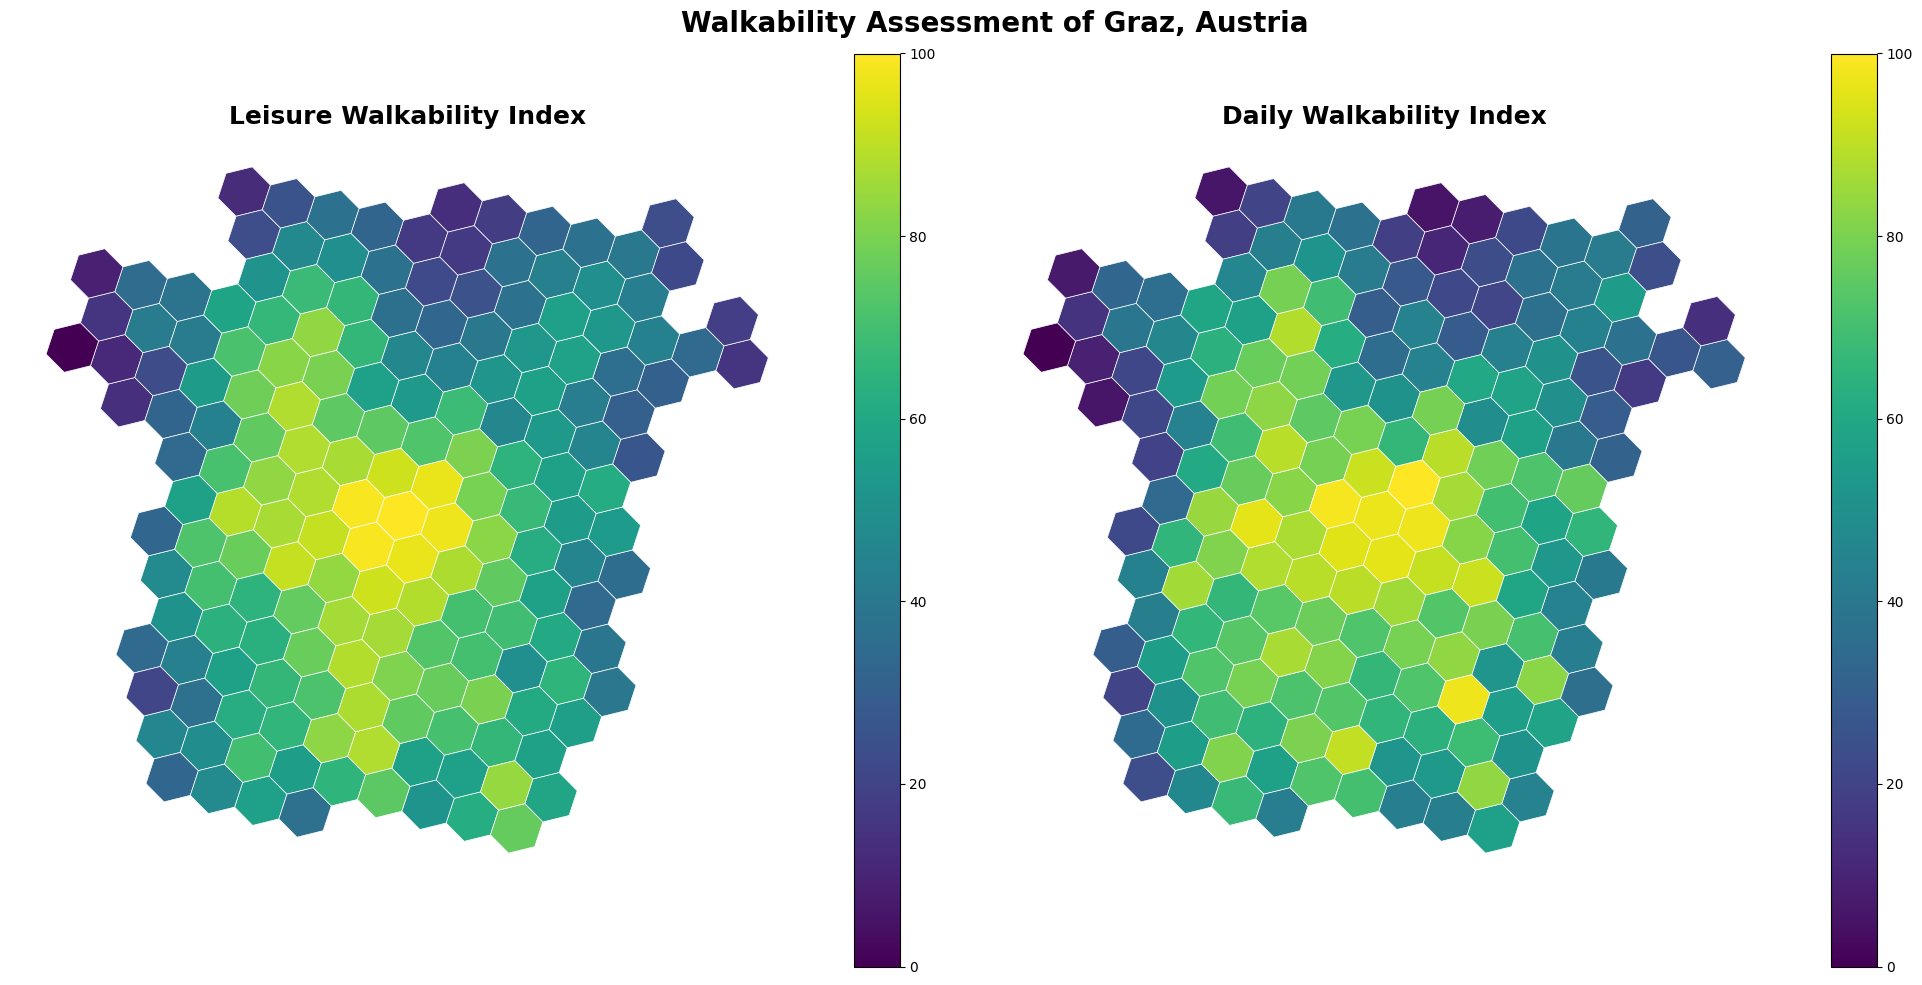

In [322]:
# Walkability Visualization for Graz
fig, axes = plt.subplots(1, 2, figsize=(20, 10))

# Leisure Walkability
gdf_hex.plot(
    column='walkability_leisure',
    cmap='viridis',              
    linewidth=0.5,
    edgecolor='white',
    legend=True,
    ax=axes[0],
    vmin=0,
    vmax=100
)
axes[0].set_title('Leisure Walkability Index', fontsize=18, fontweight='bold')
axes[0].axis('off')

# Daily Walkability
gdf_hex.plot(
    column='walkability_daily',
    cmap='viridis',              
    linewidth=0.5,
    edgecolor='white',
    legend=True,
    ax=axes[1],
    vmin=0,
    vmax=100
)
axes[1].set_title('Daily Walkability Index', fontsize=18, fontweight='bold')
axes[1].axis('off')

plt.suptitle('Walkability Assessment of Graz, Austria', 
             fontsize=20, fontweight='bold', y=0.98)

plt.tight_layout()
plt.show()

In [323]:
gdf_for_kepler = gdf_hex.to_crs("EPSG:4326").copy()

# Keep only relevant columns
cols_keep = [
    "h3_cells", "name", "geometry",
    "walkability_leisure", "walkability_daily",
    "green_blue_pct", "pop_density", "slope_deg"
]
gdf_for_kepler = gdf_for_kepler[cols_keep]

# --- Map 1: Walkability Leisure ---
map_leisure = KeplerGl(height=600)
map_leisure.add_data(data=gdf_for_kepler, name="Graz Walkability Leisure")
map_leisure  

User Guide: https://docs.kepler.gl/docs/keplergl-jupyter


KeplerGl(data={'Graz Walkability Leisure': {'index': [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16…

In [324]:
# --- Map 2: Walkability Daily ---
map_daily = KeplerGl(height=600)
map_daily.add_data(data=gdf_for_kepler, name="Graz Walkability Daily")
map_daily 

User Guide: https://docs.kepler.gl/docs/keplergl-jupyter


KeplerGl(data={'Graz Walkability Daily': {'index': [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, …

### Comparison to network-based calculation

In [325]:
def haversine(lat1, lon1, lat2, lon2):

    R = 6371000  # Earth radius in meters
    lat1, lon1, lat2, lon2 = map(np.radians, [lat1, lon1, lat2, lon2])
    dlat = lat2 - lat1
    dlon = lon2 - lon1
    a = np.sin(dlat/2)**2 + np.cos(lat1)*np.cos(lat2)*np.sin(dlon/2)**2
    return 2 * R * np.arcsin(np.sqrt(a))


def prefilter_pois_by_haversine(hex_lat, hex_lon, pois_df, max_distance, buffer=1.3):
    
    poi_lats = pois_df['lat'].values  
    poi_lons = pois_df['lon'].values  
    
    haversine_distances = haversine(hex_lat, hex_lon, poi_lats, poi_lons)
    nearby_mask = haversine_distances <= (max_distance * buffer)
    
    return pois_df[nearby_mask].copy()


In [326]:
def calculate_network_distances_hybrid(gdf_hex_utm, gdf_pois_utm, G, n_pois_per_category, max_distance=1500):
    
    from tqdm import tqdm
    
    walk_dist_list = []
    categories = gdf_pois_utm['category'].unique()

    stats = {
        'network': 0,
        'haversine_far': 0,
        'haversine_supplement': 0,
        'haversine_collision': 0,  
        'haversine_fallback': 0,
        'node_not_in_graph': 0
    }
    
    # Add lat/lon to POIs for haversine calculations
    gdf_pois_temp = gdf_pois_utm.copy()
    gdf_pois_temp['lat'] = gdf_pois_utm.geometry.to_crs("EPSG:4326").y
    gdf_pois_temp['lon'] = gdf_pois_utm.geometry.to_crs("EPSG:4326").x

    graph_nodes = set(G.nodes())
    
    for cat_name in tqdm(categories, desc="Processing categories"):
        
        cat_pois = gdf_pois_temp[gdf_pois_temp['category'] == cat_name].copy()
        n_needed = n_pois_per_category.get(cat_name, 1)
        
        for idx, hex_row in gdf_hex_utm.iterrows():
            hex_cell = hex_row["h3_cells"]
            hex_node = hex_row["osmid"]
            hex_lat = hex_row["lat"]
            hex_lon = hex_row["lon"]

            # Verify hex node is in graph
            if hex_node not in graph_nodes:
                stats['node_not_in_graph'] += n_needed
                all_dists = haversine(hex_lat, hex_lon, 
                                    cat_pois['lat'].values, 
                                    cat_pois['lon'].values)
                nearest_indices = np.argsort(all_dists)[:n_needed]
                
                for dist in all_dists[nearest_indices]:
                    walk_dist_list.append({
                        "h3_cells": hex_cell,
                        "category": cat_name,
                        "distance_m_walk": dist,
                        "routing_method": "haversine_hex_not_in_graph"
                    })
                continue
            
            # Pre-filter POIs using haversine (decreasing calculation time)
            nearby_pois = prefilter_pois_by_haversine(
                hex_lat, hex_lon, cat_pois, max_distance, buffer=1.5
            )
            
            if len(nearby_pois) == 0:
                stats['haversine_far'] += n_needed
                all_dists = haversine(hex_lat, hex_lon, 
                                    cat_pois['lat'].values, 
                                    cat_pois['lon'].values)
                nearest_indices = np.argsort(all_dists)[:n_needed]
                
                for dist in all_dists[nearest_indices]:
                    walk_dist_list.append({
                        "h3_cells": hex_cell,
                        "category": cat_name,
                        "distance_m_walk": dist,
                        "routing_method": "haversine_far"
                    })
                continue
            
            # Calculate network distances for nearby POIs
            try:
                # Dijkstra search from hex to all reachable nodes
                lengths = nx.single_source_dijkstra_path_length(
                    G, hex_node, cutoff=max_distance, weight='length'
                )
                
                network_distances = []
                collision_indices = []
                
                for poi_idx, poi_row in nearby_pois.iterrows():
                    poi_node = poi_row['osmid']

                    if poi_node == hex_node:
                        # Use haversine distance instead of 0
                        hav_dist = haversine(hex_lat, hex_lon, 
                                           poi_row['lat'], poi_row['lon'])
                        network_distances.append(hav_dist)
                        collision_indices.append(len(network_distances) - 1)
                    elif poi_node in lengths:
                        network_distances.append(lengths[poi_node])

                # Select n_needed nearest POIs
                if len(network_distances) >= n_needed:
                    network_distances = np.array(network_distances)
                    nearest_indices = np.argsort(network_distances)[:n_needed]
                    
                    for idx_pos in nearest_indices:
                        dist = network_distances[idx_pos]
                        
                        if idx_pos in collision_indices:
                            method = "haversine_collision"
                            stats['haversine_collision'] += 1
                        else:
                            method = "network"
                            stats['network'] += 1
                        
                        walk_dist_list.append({
                            "h3_cells": hex_cell,
                            "category": cat_name,
                            "distance_m_walk": dist,
                            "routing_method": method
                        })
                else:
                    # Add all network distances found
                    for idx_pos, dist in enumerate(network_distances):
                        # Check if this distance came from a collision
                        if idx_pos in collision_indices:
                            method = "haversine_collision"
                            stats['haversine_collision'] += 1
                        else:
                            method = "network"
                            stats['network'] += 1
                        
                        walk_dist_list.append({
                            "h3_cells": hex_cell,
                            "category": cat_name,
                            "distance_m_walk": dist,
                            "routing_method": method
                        })
                    
                    n_remaining = n_needed - len(network_distances)
                    all_dists = haversine(hex_lat, hex_lon,
                                        cat_pois['lat'].values,
                                        cat_pois['lon'].values)
                    nearest_indices = np.argsort(all_dists)[:n_remaining]
                    
                    for dist in all_dists[nearest_indices]:
                        walk_dist_list.append({
                            "h3_cells": hex_cell,
                            "category": cat_name,
                            "distance_m_walk": dist,
                            "routing_method": "haversine_supplement"
                        })
                        stats['haversine_supplement'] += 1
                        
            except (nx.NetworkXError, KeyError):
                # Haversine fallback
                stats['haversine_fallback'] += n_needed
                all_dists = haversine(hex_lat, hex_lon,
                                    cat_pois['lat'].values,
                                    cat_pois['lon'].values)
                nearest_indices = np.argsort(all_dists)[:n_remaining]
                
                for dist in all_dists[nearest_indices]:
                    walk_dist_list.append({
                        "h3_cells": hex_cell,
                        "category": cat_name,
                        "distance_m_walk": dist,
                        "routing_method": "haversine_fallback"
                    })
    
    df_result = pd.DataFrame(walk_dist_list)

    print("\n" + "="*60)
    print("ROUTING STATISTICS")
    print("="*60)
    total = sum(stats.values())
    for method, count in sorted(stats.items(), key=lambda x: x[1], reverse=True):
        pct = (count / total * 100) if total > 0 else 0
        print(f"  {method:30s}: {count:6d} ({pct:5.1f}%)")
    print(f"  {'TOTAL':30s}: {total:6d}")

    collision_pct = (stats['haversine_collision'] / total * 100) if total > 0 else 0
    print(f"\n  Node collisions fixed: {stats['haversine_collision']} ({collision_pct:.1f}%)")
    print("="*60)
    
    return df_result

In [327]:
# osmid column issue
if 'osmid' not in gdf_hex_utm.columns:
    print("  Snapping hex centroids to network nodes...")
    gdf_hex_utm["centroid"] = gdf_hex_utm.geometry.centroid
    gdf_hex_utm["x"] = gdf_hex_utm.centroid.x
    gdf_hex_utm["y"] = gdf_hex_utm.centroid.y
    gdf_hex_utm["osmid"] = ox.nearest_nodes(G, gdf_hex_utm["x"], gdf_hex_utm["y"])

# Ensure lat/lon columns exist 
if 'lat' not in gdf_hex_utm.columns or 'lon' not in gdf_hex_utm.columns:
    gdf_hex_wgs = gdf_hex_utm.to_crs("EPSG:4326")
    gdf_hex_utm["lat"] = gdf_hex_wgs.centroid.y
    gdf_hex_utm["lon"] = gdf_hex_wgs.centroid.x

# Check if gdf_pois_utm has osmid column
if 'osmid' not in gdf_pois_utm.columns:
    gdf_pois_utm["osmid"] = ox.nearest_nodes(G, gdf_pois_utm.geometry.x, gdf_pois_utm.geometry.y)

print(f"  Hexagons: {len(gdf_hex_utm)} with osmid")
print(f"  POIs: {len(gdf_pois_utm)} with osmid")

# Execute network-based distance calculation
gdf_walk_distances_network = calculate_network_distances_hybrid(
    gdf_hex_utm=gdf_hex_utm,
    gdf_pois_utm=gdf_pois_utm,
    G=G,
    n_pois_per_category=n_pois_per_category,
    max_distance=1500
)

  Snapping hex centroids to network nodes...
  Hexagons: 177 with osmid
  POIs: 10147 with osmid


Processing categories: 100%|██████████| 6/6 [00:07<00:00,  1.30s/it]


ROUTING STATISTICS
  network                       :   1456 ( 63.3%)
  haversine_supplement          :    656 ( 28.5%)
  haversine_far                 :    127 (  5.5%)
  haversine_collision           :     62 (  2.7%)
  haversine_fallback            :      0 (  0.0%)
  node_not_in_graph             :      0 (  0.0%)
  TOTAL                         :   2301

  Node collisions fixed: 62 (2.7%)


In [328]:
# Apply weights and decay to network distances (same a s haversine)

gdf_walk_leisure_network = poi_weights_with_decay(
    gdf_walk_distances_network,
    weights_leisure,
    max_distance=800,
    decay_strength=0.5
)

gdf_walk_daily_network = poi_weights_with_decay(
    gdf_walk_distances_network,
    weights_daily,
    max_distance=400,
    decay_strength=0.5
)

C:\Users\elias\AppData\Local\Temp\ipykernel_24540\563078827.py:31: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '0.9025750795244079' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  df_weighted.loc[idx, "decay_factor"] = decay_factor
C:\Users\elias\AppData\Local\Temp\ipykernel_24540\563078827.py:32: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '0.9025750795244079' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  df_weighted.loc[idx, "accessibility_contribution"] = base_weight * decay_factor
C:\Users\elias\AppData\Local\Temp\ipykernel_24540\563078827.py:31: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '0.8146417741784913' has dtype incompatible with int64, please 

Network-based accessibility scores

In [329]:
# Calculate accessibility scores (network-based)
leisure_accessibility_network = gdf_walk_leisure_network.groupby("h3_cells")["accessibility_contribution"].sum().reset_index()
leisure_accessibility_network.rename(columns={"accessibility_contribution": "accessibility_score_network"}, inplace=True)

daily_accessibility_network = gdf_walk_daily_network.groupby("h3_cells")["accessibility_contribution"].sum().reset_index()
daily_accessibility_network.rename(columns={"accessibility_contribution": "accessibility_score_network"}, inplace=True)

# Drop columns 
cols_to_drop = ['leisure_score_network', 'daily_score_network']
gdf_hex = gdf_hex.drop(columns=[col for col in cols_to_drop if col in gdf_hex.columns])

# Merge network scores into hexagon dataframe
gdf_hex = gdf_hex.merge(leisure_accessibility_network, on="h3_cells", how="left")
gdf_hex.rename(columns={"accessibility_score_network": "leisure_score_network"}, inplace=True)

gdf_hex = gdf_hex.merge(daily_accessibility_network, on="h3_cells", how="left")
gdf_hex.rename(columns={"accessibility_score_network": "daily_score_network"}, inplace=True)

gdf_hex["leisure_score_network"] = gdf_hex["leisure_score_network"].fillna(0)
gdf_hex["daily_score_network"] = gdf_hex["daily_score_network"].fillna(0)

# Calculate final network-based walkability (with variety bonus)
gdf_hex["walkability_leisure_network_raw"] = (
    WEIGHT_POI * gdf_hex["leisure_score_network"] * gdf_hex["variety_bonus_leisure"] +
    gdf_hex["env_score"]
)

gdf_hex["walkability_daily_network_raw"] = (
    WEIGHT_POI * gdf_hex["daily_score_network"] * gdf_hex["variety_bonus_daily"] +
    gdf_hex["env_score"]
)

# Normalize to 0-100
gdf_hex["walkability_leisure_network"] = normalize_to_100(gdf_hex["walkability_leisure_network_raw"])
gdf_hex["walkability_daily_network"] = normalize_to_100(gdf_hex["walkability_daily_network_raw"])

Differences

In [330]:
# Calculate differences 
gdf_hex["leisure_diff"] = gdf_hex["walkability_leisure_network"] - gdf_hex["walkability_leisure"]
gdf_hex["daily_diff"] = gdf_hex["walkability_daily_network"] - gdf_hex["walkability_daily"]
gdf_hex["total_diff"] = gdf_hex["leisure_diff"].abs() + gdf_hex["daily_diff"].abs()

print("\nLEISURE WALKABILITY:")
print(f"  Haversine mean: {gdf_hex['walkability_leisure'].mean():.2f}")
print(f"  Network mean:   {gdf_hex['walkability_leisure_network'].mean():.2f}")
print(f"  Mean difference: {gdf_hex['leisure_diff'].mean():.2f}")
print(f"  Max difference:  {gdf_hex['leisure_diff'].abs().max():.2f}")

print("\nDAILY WALKABILITY:")
print(f"  Haversine mean: {gdf_hex['walkability_daily'].mean():.2f}")
print(f"  Network mean:   {gdf_hex['walkability_daily_network'].mean():.2f}")
print(f"  Mean difference: {gdf_hex['daily_diff'].mean():.2f}")
print(f"  Max difference:  {gdf_hex['daily_diff'].abs().max():.2f}")

# Correlation between methods
corr_leisure = gdf_hex['walkability_leisure'].corr(gdf_hex['walkability_leisure_network'])
corr_daily = gdf_hex['walkability_daily'].corr(gdf_hex['walkability_daily_network'])

print(f"\nCORRELATION (Haversine vs Network):")
print(f"  Leisure: {corr_leisure:.3f}")
print(f"  Daily:   {corr_daily:.3f}")

# Areas with biggest differences
print("\nTop 5 hexagons with biggest differences:")
top_diff = gdf_hex.nlargest(5, "total_diff")
print(top_diff[["name", "walkability_leisure", "walkability_leisure_network", 
               "walkability_daily", "walkability_daily_network"]].to_string(index=False))



LEISURE WALKABILITY:
  Haversine mean: 56.57
  Network mean:   53.69
  Mean difference: -2.88
  Max difference:  28.76

DAILY WALKABILITY:
  Haversine mean: 55.93
  Network mean:   46.66
  Mean difference: -9.26
  Max difference:  41.15

CORRELATION (Haversine vs Network):
  Leisure: 0.971
  Daily:   0.942

Top 5 hexagons with biggest differences:
     name  walkability_leisure  walkability_leisure_network  walkability_daily  walkability_daily_network
     Lend            86.981168                    58.220537          79.047697                  37.901011
 Puntigam            87.563415                    63.049730          72.817316                  42.329113
 Jakomini            92.497862                    79.149652          89.758111                  59.131470
  Andritz            66.529570                    51.227845          57.150780                  30.332855
Straßgang            65.443281                    49.731604          64.448486                  39.196206


Visualization

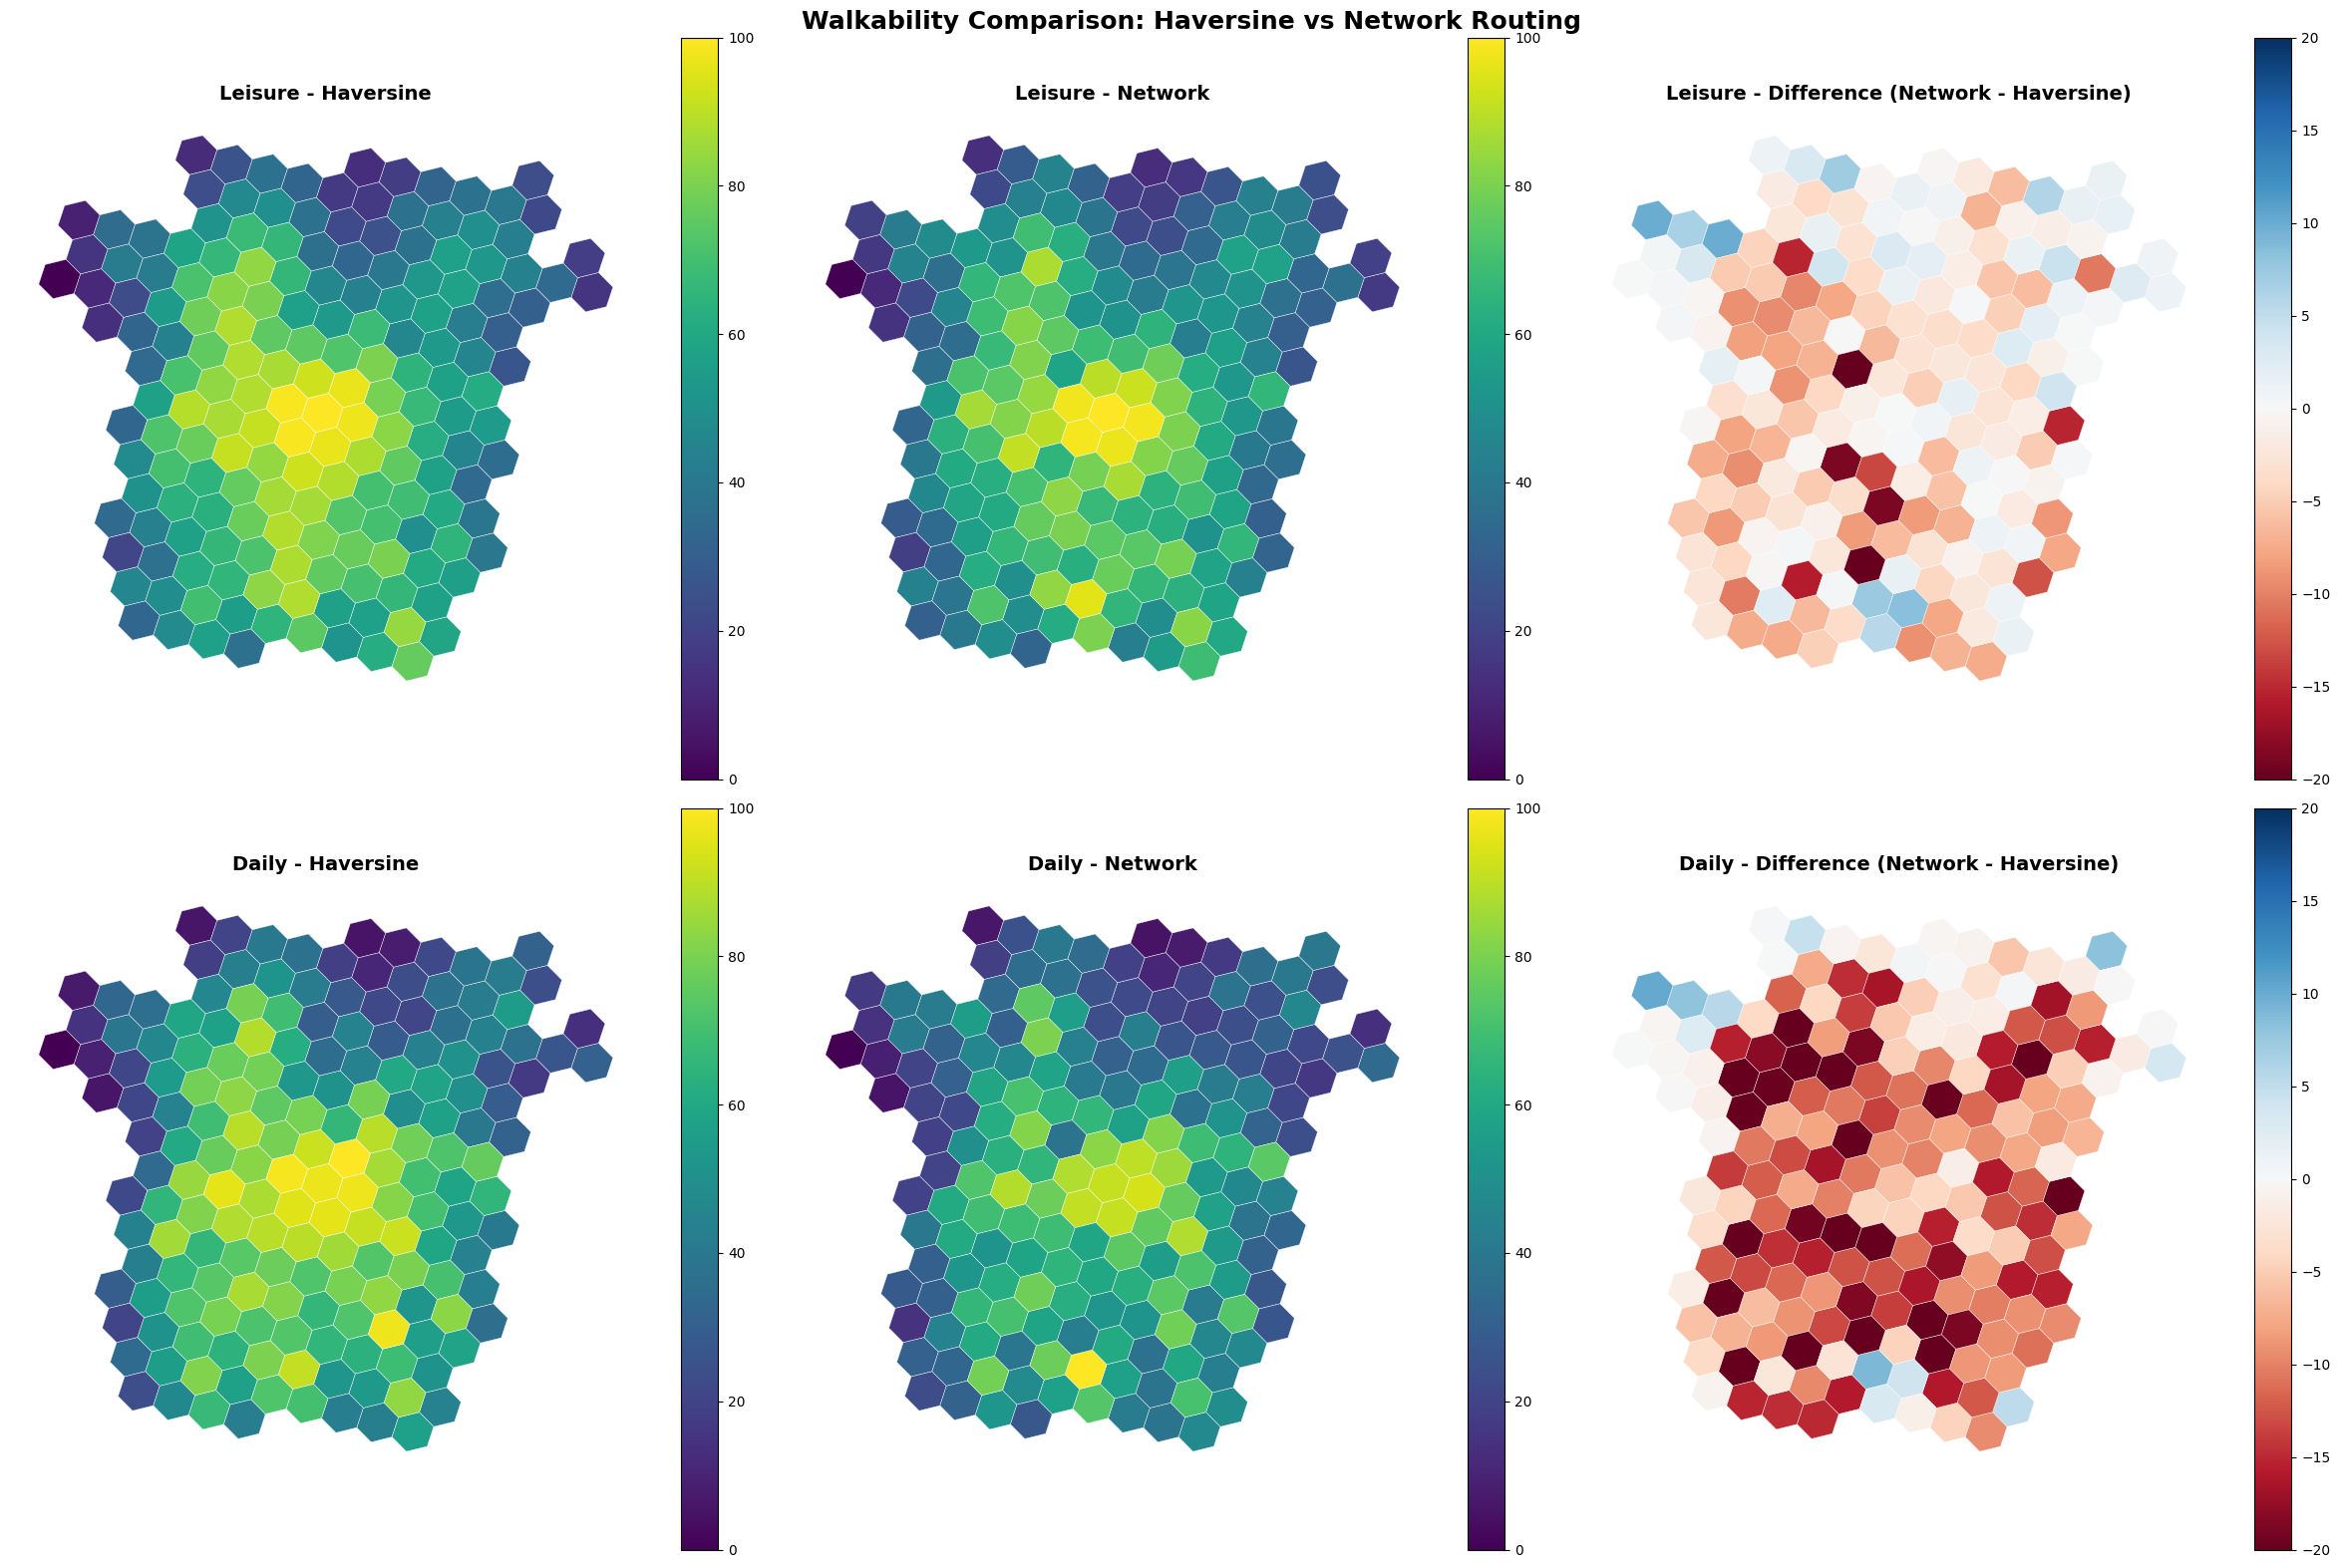

In [331]:
fig, axes = plt.subplots(2, 3, figsize=(24, 16))

# Row 1: LEISURE
axes[0, 0].set_title('Leisure - Haversine', fontsize=14, fontweight='bold')
gdf_hex.plot(column='walkability_leisure', cmap='viridis', linewidth=0.3,
             edgecolor='white', legend=True, ax=axes[0, 0], vmin=0, vmax=100)
axes[0, 0].axis('off')

axes[0, 1].set_title('Leisure - Network', fontsize=14, fontweight='bold')
gdf_hex.plot(column='walkability_leisure_network', cmap='viridis', linewidth=0.3,
             edgecolor='white', legend=True, ax=axes[0, 1], vmin=0, vmax=100)
axes[0, 1].axis('off')

axes[0, 2].set_title('Leisure - Difference (Network - Haversine)', fontsize=14, fontweight='bold')
gdf_hex.plot(column='leisure_diff', cmap='RdBu', linewidth=0.3,
             edgecolor='white', legend=True, ax=axes[0, 2], vmin=-20, vmax=20)
axes[0, 2].axis('off')

# Row 2: DAILY
axes[1, 0].set_title('Daily - Haversine', fontsize=14, fontweight='bold')
gdf_hex.plot(column='walkability_daily', cmap='viridis', linewidth=0.3,
             edgecolor='white', legend=True, ax=axes[1, 0], vmin=0, vmax=100)
axes[1, 0].axis('off')

axes[1, 1].set_title('Daily - Network', fontsize=14, fontweight='bold')
gdf_hex.plot(column='walkability_daily_network', cmap='viridis', linewidth=0.3,
             edgecolor='white', legend=True, ax=axes[1, 1], vmin=0, vmax=100)
axes[1, 1].axis('off')

axes[1, 2].set_title('Daily - Difference (Network - Haversine)', fontsize=14, fontweight='bold')
gdf_hex.plot(column='daily_diff', cmap='RdBu', linewidth=0.3,
             edgecolor='white', legend=True, ax=axes[1, 2], vmin=-20, vmax=20)
axes[1, 2].axis('off')

plt.suptitle('Walkability Comparison: Haversine vs Network Routing',
             fontsize=18, fontweight='bold', y=0.98)
plt.tight_layout()
plt.show()